In this post I am implementing Conformal Prediction for Regression

# Conformal Prediction for Classification

Conformal Prediction is a versatile framework applicable to various scenarios, including classification tasks. The algorithm's adaptation for classification is outlined as follows:

1. **Heuristic Notion of Uncertainty**: Start with a pre-trained model that generates predictions for input data. The model should possess a heuristic notion of uncertainty that represents its prediction confidence.

2. **Conformal Scores Calculation**: Compute the conformal scores by applying the trained model to the calibration dataset. The socring function is

### $$s_i=1-\hat{\pi}_{x_i}(y_i)$$


In [111]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
import torchvision.datasets as datasets
import torchvision.transforms as transforms
torch.manual_seed(42)
np.random.seed(42)

In [112]:
def get_data():

    train_dataset = datasets.MNIST(root='blogs/posts/data', train=True, download=True)
    test_dataset = datasets.MNIST(root='blogs/posts/data', train=False, download=True)

    X_train, y_train = train_dataset.data.float() / 255.0, train_dataset.targets
    X_test, y_test = test_dataset.data.float() / 255.0, test_dataset.targets

    X_train = X_train.view(-1, 28*28)
    X_test = X_test.view(-1, 28*28)

    X_calib, X_train = X_train[59500:], X_train[:59500]
    y_calib, y_train = y_train[59500:], y_train[:59500]

    return X_train, y_train, X_test, y_test, X_calib, y_calib

In [113]:
X_train, y_train, X_test, y_test, X_cal, y_cal = get_data()

In [114]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 32)
        self.relu = nn.ReLU()
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [115]:
def train(_net, _train_data):
    X_train, y_train = _train_data
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(_net.parameters(), lr=0.001)
    num_epochs = 1
    
    for epoch in range(num_epochs):
        _net.train()
        running_loss = 0.0
        running_accuracy = 0.0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = _net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # running_accuracy += accuracy(outputs, targets)
  
    return _net

In [116]:
net = MLP()
net = train(net, (X_train, y_train))


In [117]:
y_test_pred = torch.argmax(net(X_test), dim = 1)
accuracy = (y_test_pred == y_test).sum()/len(y_test)
print(f"accuracy : {accuracy}")


accuracy : 0.9197999835014343


In [118]:
cal_smx = torch.functional.F.softmax(net(X_calib), dim=1).detach().numpy()
scores = 1 - cal_smx[np.arange(len(X_calib)), y_calib.numpy()]


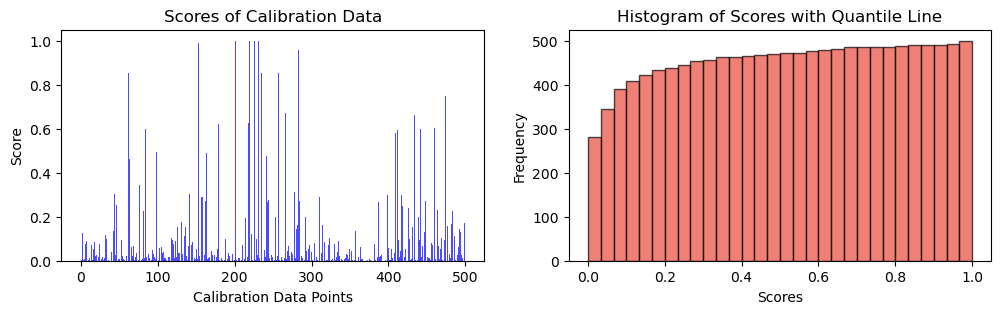

(None,)

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
# Plot scores of calibration data
ax[0].bar(np.arange(len(scores)), height = scores, alpha = 0.7, color = 'b')
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Calibration Data Points")
ax[0].set_title("Scores of Calibration Data")

# Plot the histogram
n, bins, _ = ax[1].hist(scores, bins=30, alpha=0.7, cumulative = True, color='#E94B3CFF', edgecolor='black', label='Score Frequency')
ax[1].set_xlabel('Scores')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Scores with Quantile Line')
plt.show(),

In [120]:
alpha = 0.1
n_cal = 500

# $$q = \frac{{\lceil (1 - \alpha) \cdot (n + 1) \rceil}}{{n}}$$

In [121]:
q_val = np.ceil((1 - alpha) * (n_cal + 1)) / n_cal
print(f"q_val: {q_val}")

q_val: 0.902


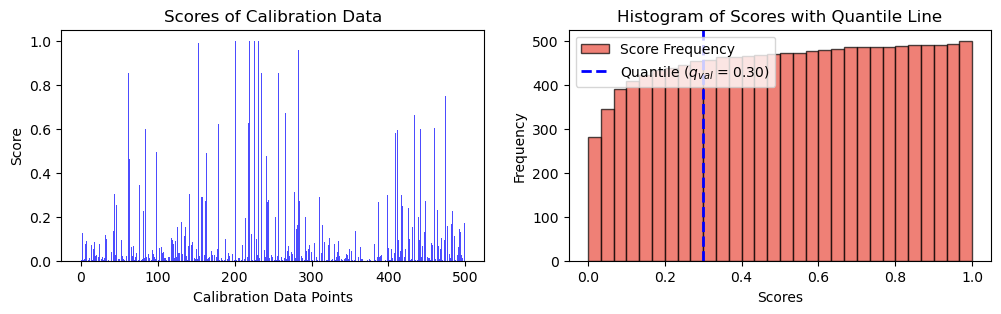

(None,)

In [122]:
q = np.quantile(scores, q_val, method="higher")
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
# Plot scores of calibration data
ax[0].bar(np.arange(len(scores)), height = scores, alpha = 0.7, color = 'b')
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Calibration Data Points")
ax[0].set_title("Scores of Calibration Data")

# Plot the histogram
n, bins, _ = ax[1].hist(scores, bins=30, alpha=0.7, cumulative = True, color='#E94B3CFF', edgecolor='black', label='Score Frequency')

# Plot the vertical line at the quantile
# q_x = np.quantile(scores, q)
ax[1].axvline(q, color='b', linestyle='dashed', linewidth=2, label=r"Quantile (${q_{val}}$ = " + str(("{:.2f}")).format(q) + ")")

ax[1].set_xlabel('Scores')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Scores with Quantile Line')
plt.legend()
plt.show(),

In [123]:
idxs = 976

In [124]:
def get_test_preds_and_smx(X_test, index, pred_sets, net, q, alpha):
    test_smx = nn.functional.softmax(net(X_test), dim=1).detach().numpy()
    sample_smx = test_smx[index]
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    axs[0].imshow(X_test[index].reshape(28,28).numpy())
    axs[0].set_title("Sample test image")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    
    axs[1].bar(range(10), sample_smx, label="class scores", color = '#5B84B1FF')
    axs[1].set_xticks(range(10))
    axs[1].set_xticklabels([class_label(i) for i in range(10)])
    axs[1].axhline(y=1 - q, label='threshold', color="#FC766AFF", linestyle='dashed')
    axs[1].legend(loc=1)
    axs[1].set_title("Class Scores")
    
    pred_set = pred_sets[index].nonzero()[0].tolist()
    
    return fig, axs, pred_set, get_pred_str(pred_set)


In [125]:
def class_label(i):
    labels = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 
                5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    return labels[i]

In [126]:
def get_pred_str(pred):
    pred_str = "{"
    for i in pred:
        pred_str += class_label(i) + ', '  # Use comma instead of space
    pred_str = pred_str.rstrip(', ') + "}"  # Remove the trailing comma and add closing curly brace
    return pred_str


In [127]:
def get_pred_sets(net, test_data, q, alpha):
    X_test, y_test = test_data
    test_smx = nn.functional.softmax(net(X_test), dim=1).detach().numpy()

    pred_sets = test_smx >= (1 - q)
    return pred_sets


In [128]:
pred_sets = get_pred_sets(net, (X_test, y_test), q, alpha)

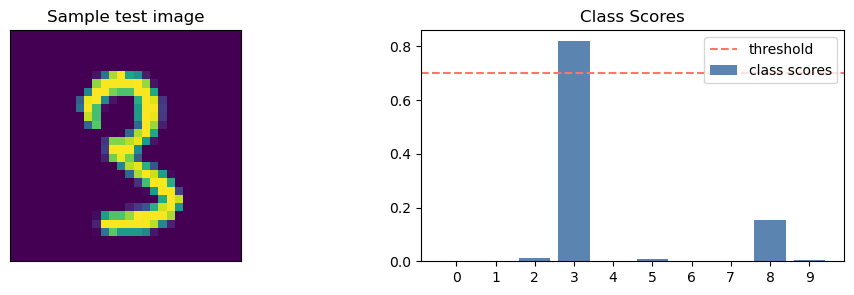

In [129]:
fig, ax, pred, pred_str = get_test_preds_and_smx(X_test, idxs, pred_sets, net, q, alpha)

In [130]:
print(pred_str)

{3}
